imports

In [6]:
import ast
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from tg.grammar_ru.common import Loc
from tg.grammar_ru.corpus import CorpusReader, CorpusBuilder, BucketCorpusBalancer
from tg.grammar_ru.corpus.corpus_reader import read_data
import os
from pathlib import Path
from dotenv import load_dotenv
from tg.grammar_ru.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
from tg.grammar_ru.components.yandex_delivery.training_logs import S3TrainingLogsLoader, TrainingLogsViewer

from yo_fluq_ds import Queryable, Query, fluq
import plotly.express as px
from tg.grammar_ru.common import Separator

from typing import List, Union
import numpy as np
import math
import pandas as pd
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 500)
load_dotenv(Loc.root_path / 'environment.env')


def get_tasks(bucket, tasks_list_s3_path):
    tmp_local_file = Loc.temp_path / tasks_list_s3_path.split('/')[-1]
    S3YandexHandler.download_file(bucket, tasks_list_s3_path, tmp_local_file)
    with open(tmp_local_file, 'r') as f:
        tasks = ast.literal_eval(f.read())
    return tasks


def plot_metrics(metrics, title=""):
    plt.plot(TrainingLogsViewer.get_metric_by_job(
        metrics, 'accuracy_display'), label='accuracy_display')
    plt.plot(TrainingLogsViewer.get_metric_by_job(
        metrics, 'accuracy_test'), label='accuracy_test')
    plt.title(title)
    plt.legend()
    plt.show()


def plot_cm(cm):
    fig = go.Figure(data=go.Heatmap(z=cm,
                                    text=cm,
                                    x=cm.columns,
                                    y=cm.index,
                                    texttemplate="%{text}",
                                    colorscale='Blues'))
    fig.show()

def get_label(s):
    return int(s.split('_label_')[1])

def get_true_and_pred(result_df):
    pred_col_names = [c for c in result_df.columns if 'predicted_label' in c ]
    true_col_names = [c for c in result_df.columns if 'true_label' in c ]
    y_pred = result_df[pred_col_names].idxmax(axis="columns").apply(get_label)
    true_probs = result_df[true_col_names]
    y_true = true_probs.idxmax(axis="columns").apply(get_label)

    result_df['pred_label'] = y_pred
    result_df['true_label'] = y_true
    result_df['pred_score'] = result_df[pred_col_names].max(axis=1)

    return y_true, y_pred

def get_worst_words_sents(result_df, src, true_label: int, pred_label: int, worst_words_cnt: int):
    one_inst_another = result_df[(result_df.true_label == true_label) & (
        result_df.pred_label == pred_label)]
    thrsh = one_inst_another[f'predicted_label_{pred_label}'].sort_values(
        ascending=False).head(worst_words_cnt).min()
    worst_mistakes_scores = one_inst_another[
        one_inst_another[f'predicted_label_{pred_label}'] >= thrsh]

    worst_words = (src[src.word_id.isin(worst_mistakes_scores.word_id)]
                   [['word_id', 'sentence_id', 'word']])[:worst_words_cnt]
    worst_sents = worst_words['sentence_id'].unique()
    worst_sents_df = src[src.sentence_id.isin(worst_sents)]
    # worst_sents_df.loc[worst_sents_df.index, 'pred_score'] = -1
    # worst_sents_df.loc[worst_sents_df[worst_sents_df.word_id.isin(worst_mistakes_scores.word_id)].index, "pred_score"] = one_inst_another.pred_score.values
    return worst_words, worst_sents_df

def get_best_words_sents(result_df, src, pred_label: int, words_cnt: int):
    """ 
    Находит слова, в которых сеть была уверена в ответе и ответ верный
    """
    correct_df = result_df[result_df.true_label==pred_label]
    thrsh = correct_df[f'predicted_label_{pred_label}'].sort_values(
        ascending=False).head(words_cnt).min()
    best_scores = correct_df[correct_df[f'predicted_label_{pred_label}']>=thrsh]
    best_words = (src[src.word_id.isin(best_scores.word_id)])[['word_id', 'sentence_id', 'word']][:words_cnt]
    best_sents = best_words.sentence_id.unique()
    best_sents_df = src[src.sentence_id.isin(best_sents)]
    return best_words, best_sents_df


In [7]:
project_name = 'agreementproject'
dataset_name = 'agreement_adj_mid50_0_declination'
bucket = 'agreementadjbucket'

Измененный бандл:
* Удалили slovnet
* Удалили ОЮ

### Filter bundle

In [8]:
new = {'ая', 'ого', 'ое', 'ой', 'ом', 'ому',
       'ую', 'ые', 'ый', 'ым', 'ыми', 'ых'} # тут нет окнчаний превосходных форм и ою

# полнейшей, наипрочнейшего, важнейшие,меньшим, милейший, наистраннейшее, новейших, малейшем, слабейшему, меньшими
good = {'ая', 'его', 'ее', 'ей', 'ем', 'ему',
        'ие', 'ий', 'им', 'ими', 'их', 'ую', 'яя', 'юю'}

big = {'ая', 'ие', 'им', 'ими', 'их', 'ого',
       'ое', 'ой', 'ом', 'ому', 'ою', 'ую'}

POSSIBLE_ENDINGS = set().union(new, good, big)
endings_nums = {e: i for i, e in enumerate(
    sorted(list(POSSIBLE_ENDINGS)))}
num_by_ending = endings_nums
ending_by_num = {v:k for k, v in endings_nums.items()}

new_declination_labels = {num for e, num in endings_nums.items() if e in new}


В датасете только слова 1-го типа склонения. Новый. Возможно 12 окончаний. 

In [9]:
new_num_by_ending = {e:num for e,num in num_by_ending.items() if e in new}
new_num_by_ending

{'ая': 0,
 'ого': 11,
 'ое': 12,
 'ой': 13,
 'ом': 14,
 'ому': 15,
 'ую': 17,
 'ые': 18,
 'ый': 19,
 'ым': 20,
 'ыми': 21,
 'ых': 22}

Оставили только слова типа "Новый"

In [15]:
from tg.common import DataBundle
from tg.common.ml.batched_training import IndexedDataBundle
from tg.grammar_ru.components.plain_context_builder import PlainContextBuilder
bundle_0_declination_path = Loc.data_cache_path/'bundles/agreement/mid50_0_declination'
# bundle_full_0_declination_path = Loc.data_cache_path/'bundles/agreement/full_mystemless_0_declination'


In [14]:
# db = DataBundle.load(Loc.data_cache_path/'bundles/agreement/mid50')
# ids_0_type=set(db.src[db.src.declension_type==0].word_id)
# db['index'] = db.index[db.index.word_id.isin(ids_0_type) & db.index.label.isin(new_declination_labels)]
# db = db.copy()
# db.save(bundle_0_declination_path)

Проверим отфильтрованный бандл

In [16]:
del db
db = DataBundle.load(bundle_0_declination_path)


In [17]:
db

{'index': {'shape': (88060, 4), 'index_name': 'sample_id'}, 'pymorphy': {'shape': (2499338, 16), 'index_name': 'word_id'}, 'src': {'shape': (2499338, 18), 'index_name': None}}

In [18]:
db.src[db.src.word_id.isin(db.index.word_id)].declension_type.unique()

array([0])

In [19]:
# Все возможные окончания слов 0-го типа склонения. "Новый"
db.index.label.replace(ending_by_num).unique()

array(['ые', 'ого', 'ый', 'ых', 'ой', 'ая', 'ое', 'ом', 'ую', 'ому', 'ым',
       'ыми'], dtype=object)

Отправка бандла

In [24]:
project_name = 'agreementproject'
# dataset_name = 'agreement_adj_mid50_0_declination'
dataset_name = 'agreement_adj_toy'

bucket = 'agreementadjbucket'

In [ ]:
from tg.grammar_ru.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
# try:
#     S3YandexHandler.create_bucket(bucket)
# except:
#     pass 

In [23]:
s3path = f'datasphere/{project_name}/datasets/{dataset_name}'
S3YandexHandler.upload_folder(bucket, s3path, bundle_0_declination_path)

# Обучение

Добавим в сеть кросс-энтропию.

cross-entropy & softmax 40ep

output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


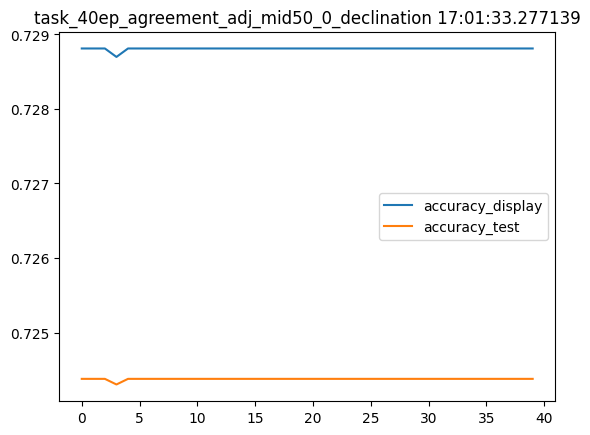

In [13]:
tasks = get_tasks(bucket, 'datasphere/agreementproject/job_info/job_agreementproject_17:01:33.277101.txt')

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)

unzipped_folder = (Loc.root_path /
                   'temp'/'training_results' /
                   f'{tasks[0]}.unzipped')
result_df = pd.read_parquet(unzipped_folder/'output'/'result_df.parquet')
y_true, y_pred = get_true_and_pred(result_df)

plot_metrics(metrics, tasks[0])
sorted_nums = sorted(list(y_true.unique()))
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred,
                     #    normalize='true'
                     ).round(2),
    columns=[f'pred {n,ending_by_num[n]}' for n in sorted_nums],
    index=[f'actual {n,ending_by_num[n]}' for n in sorted_nums]
)
plot_cm(cm)


In [45]:
pred_col_names = [c for c in result_df.columns if 'predicted_label' in c ]
true_col_names = [c for c in result_df.columns if 'true_label' in c ]

Не учится :(
    
Попробуем c mse

output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


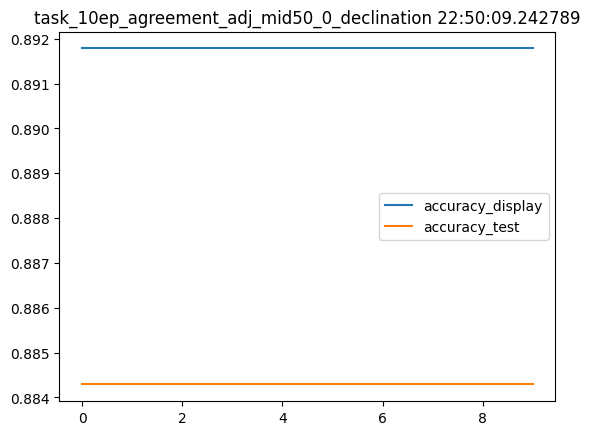

In [14]:
tasks = get_tasks(bucket, 'datasphere/agreementproject/job_info/job_agreementproject_22:50:09.242641.txt')

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)

unzipped_folder = (Loc.root_path /
                   'temp'/'training_results' /
                   f'{tasks[0]}.unzipped')
result_df = pd.read_parquet(unzipped_folder/'output'/'result_df.parquet')
y_true, y_pred = get_true_and_pred(result_df)

plot_metrics(metrics, tasks[0])
sorted_nums = sorted(list(y_true.unique()))
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred,
                     #    normalize='true'
                     ).round(2),
    columns=[f'pred {n,ending_by_num[n]}' for n in sorted_nums],
    index=[f'actual {n,ending_by_num[n]}' for n in sorted_nums]
)
plot_cm(cm)


In [17]:
# metrics[metrics.metric=='accuracy_display']

In [19]:
metrics[metrics.metric=='loss']

,metric,ordinal,value,timestamp,job_id
2,loss,0,0.061114,2023-04-06 22:51:04.707831,task_10ep_agreement_adj_mid50_0_declination 22...
6,loss,1,0.060411,2023-04-06 22:51:29.059634,task_10ep_agreement_adj_mid50_0_declination 22...
10,loss,2,0.060494,2023-04-06 22:51:59.311844,task_10ep_agreement_adj_mid50_0_declination 22...
14,loss,3,0.060412,2023-04-06 22:52:32.019444,task_10ep_agreement_adj_mid50_0_declination 22...
18,loss,4,0.060411,2023-04-06 22:53:01.664351,task_10ep_agreement_adj_mid50_0_declination 22...
22,loss,5,0.060410,2023-04-06 22:53:35.240316,task_10ep_agreement_adj_mid50_0_declination 22...
26,loss,6,0.060410,2023-04-06 22:54:05.628479,task_10ep_agreement_adj_mid50_0_declination 22...
30,loss,7,0.060410,2023-04-06 22:54:34.015237,task_10ep_agreement_adj_mid50_0_declination 22...
34,loss,8,0.060410,2023-04-06 22:55:00.975341,task_10ep_agreement_adj_mid50_0_declination 22...
38,loss,9,0.060410,2023-04-06 22:55:28.172900,task_10ep_agreement_adj_mid50_0_declination 22...


output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


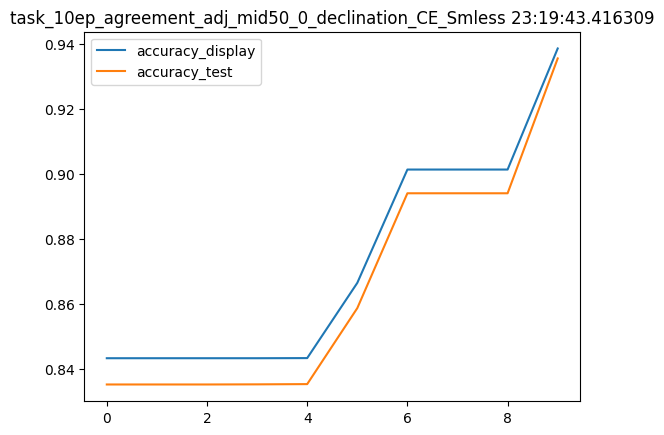

In [10]:
tasks = get_tasks(bucket, 'datasphere/agreementproject/job_info/job_agreementproject_23:19:43.416043.txt')

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)

unzipped_folder = (Loc.root_path /
                   'temp'/'training_results' /
                   f'{tasks[0]}.unzipped')
result_df = pd.read_parquet(unzipped_folder/'output'/'result_df.parquet')
y_true, y_pred = get_true_and_pred(result_df)

plot_metrics(metrics, tasks[0])
sorted_nums = sorted(list(y_true.unique()))
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred,
                     #    normalize='true'
                     ).round(2),
    columns=[f'pred {n,ending_by_num[n]}' for n in sorted_nums],
    index=[f'actual {n,ending_by_num[n]}' for n in sorted_nums]
)
plot_cm(cm)


output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


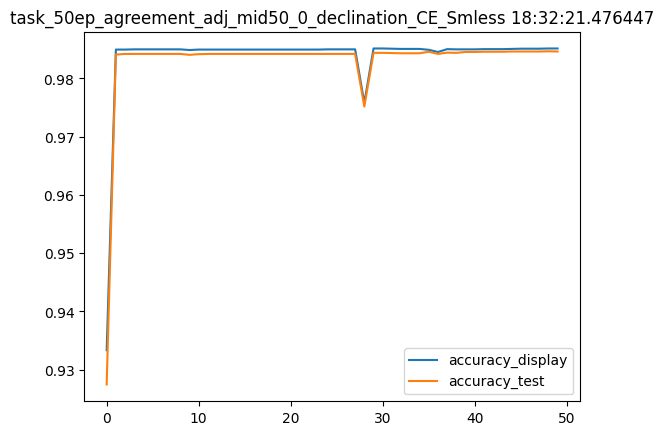

In [14]:
tasks = get_tasks(bucket,
 'datasphere/agreementproject/job_info/job_agreementproject_18:32:21.476408.txt')

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)

unzipped_folder = (Loc.root_path /
                   'temp'/'training_results' /
                   f'{tasks[0]}.unzipped')
result_df = pd.read_parquet(unzipped_folder/'output'/'result_df.parquet')
y_true, y_pred = get_true_and_pred(result_df)

plot_metrics(metrics, tasks[0])
sorted_nums = sorted(list(y_true.unique()))
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred,
                        # normalize='true'
                     ).round(2),
    columns=[f'pred {ending_by_num[n]}' for n in sorted_nums],
    index=[f'actual {ending_by_num[n]}' for n in sorted_nums]
)
plot_cm(cm)
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred,
                        normalize='true'
                     ).round(2),
    columns=[f'pred {ending_by_num[n]}' for n in sorted_nums],
    index=[f'actual {ending_by_num[n]}' for n in sorted_nums]
)
plot_cm(cm)